# Transactions Analysis using Machine Learning: Classifying Personal Text Messages

# Introduction:

Have you ever found yourself drowning in a sea of text messages from your bank, wondering how to keep track of your expenses and transactions? Fear not, because machine learning can help! In this notebook, we will explore how to use machine learning techniques to classify personal text messages into different categories based on their content. Specifically, we will focus on a project called Transactions Analysis, where we classify personal text messages into three categories: Info, Received, and Spent.

The Info category includes messages related to account information, recharge bills, and due dates, while the Received category includes messages related to money received in your bank account. The Spent category includes messages related to money spent from your bank account. We will demonstrate how to use machine learning algorithms to classify these messages accurately and efficiently.

# Data Collection:

To collect the data for this project, I created a Flutter app that reads messages from an Android phone and send them to the FastAPI server. Using this server we converted the messages received as json to a csv file.

FastAPI is a modern, fast (high-performance), web framework for building APIs with Python. With FastAPI, I was able to quickly set up a server that could receive the messages as json and convert it for use in our machine learning algorithms.

The Flutter app was created specifically to read messages from an Android phone and convert them into a format that could be easily processed by our server. By using Flutter, we were able to create a mobile app that was both efficient and user-friendly, making it easy for anyone to collect and process personal text messages for use in machine learning projects.

By combining FastAPI and Flutter, we were able to create a powerful data collection tool that streamlined the process of gathering personal text messages for the Transactions Analysis project. With our data in hand, we are ready to move on to the next stage of the project: data processing and analysis.

In [2]:
### Importing Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import tensorflow as tf
import string
from tensorflow.keras.layers import Dense,TextVectorization,GlobalAveragePooling1D,Embedding,Dropout
from sklearn.model_selection import train_test_split

# Data Information:

In [3]:
sns.set_style('darkgrid') # set plot style 
dt = pd.read_csv('sample.csv')
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6957 entries, 0 to 6956
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mess_id   6957 non-null   int64 
 1   mess_dat  6957 non-null   object
 2   mess_add  6957 non-null   object
 3   mess_bod  6953 non-null   object
dtypes: int64(1), object(3)
memory usage: 217.5+ KB


 Our Data has 4 different columns 
   1. mess_id is the id associated with the messages unique values.
   2. mess_dat is the date on which the message was received.
   3. mess_add represents sender address.
   4. mess_bod the actual text message received.
   5. There are total of 6957 messages as I have turned my backup on since very long I guess😊
   6. Mess_body has some Null values.

In [4]:
print(f"{round(dt.mess_bod.isnull().sum()/dt.shape[0] * 100,2)} % of data  is null, total of {dt.mess_bod.isnull().sum()} null messages.")

0.06 % of data  is null, total of 4 null messages.


Drop the null values.

In [5]:
dt.dropna(inplace = True)
dt.isnull().sum()

mess_id     0
mess_dat    0
mess_add    0
mess_bod    0
dtype: int64

## Data Wrangling

To analyse 6000+ texts daily is a tedious task so I took a shortcut and created a list of word that are most likely to appear in an transactional message. Then I created a function named cat_transactions to classify the text in two different category based on a condition.

The cat_transactions function works by first splitting the text message into individual words using the split function. It then checks each word against a list of transaction-related words, such as "received," "sent," "debited," and "credited." If any of these words are found in the message, the function returns "Transaction." Otherwise, it returns "Other."

By using this function, I was able to quickly identify transactions within my text message data. As most of the words that are related to transactions from bank have these set of words in them, There are many different ways we can even further identified the words common in transactional messages.

In [6]:
def cat_transactions(x):
    x = str(x).split(" ")
    transaction_words = ["received","sent","transaction","debited","credited","db","cr","card","rs"]
    for words in transaction_words:
        if words in x:
            return "Transaction"
    
    return "Other"

We convert the text messages into lowercase and then apply the above funtion on the message body to classify our text messages.

In [7]:
dt["mess_bod"] = dt["mess_bod"].str.lower()
dt["mess_type"] = dt["mess_bod"].apply(cat_transactions)

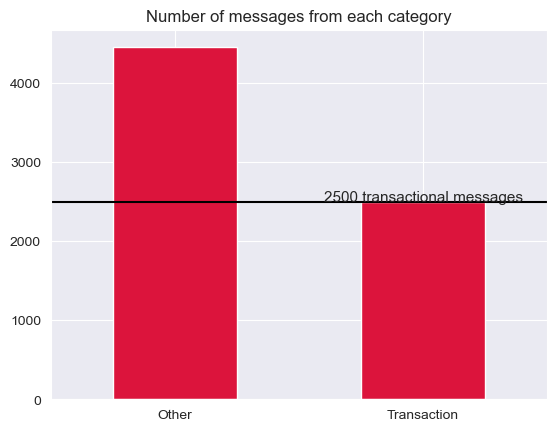

In [8]:
dt.mess_type.value_counts().plot(kind = 'bar',
                                 title="Number of messages from each category", color="crimson")
plt.axhline(dt.mess_type.value_counts()[1],color = 'black',)
plt.annotate(f"{dt.mess_type.value_counts()[1]} transactional messages",xy=(0.6,2500),fontsize = 11)
plt.xticks(rotation = 0)
plt.show()

Saving only the Transaction messages to the dataframe.

In [9]:
dt = dt[dt.mess_type == 'Transaction'] 

Our Objective is to classify these transaction messages into Info, Received and Spent categories. To train a supervisied learning model we need a label dataset.

To achieve this I have implemented yet another function div_transactions that will divide the transactions messages into three categories.

In [10]:
def div_transactions(x):
    x = str(x).split(" ")
    received_words = ["received","credited","cr"]
    spend_words = ["sent","debited","db"]
    for words in received_words:
        if words in x:
            return "Received"
    
    for words in spend_words:
        if words in x:
            return "Spent"
    
    return "Info"

transac_type = dt["mess_bod"].apply(div_transactions)
dt['transac_type'] = transac_type

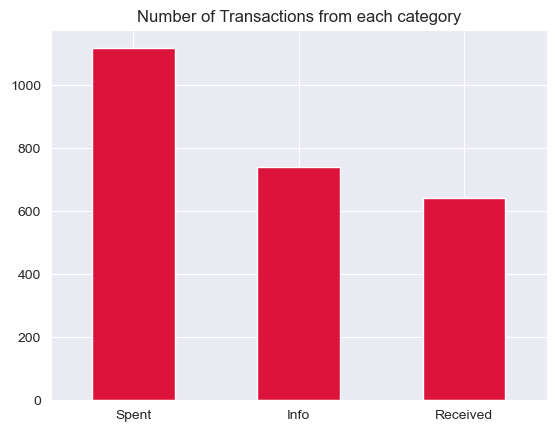

In [11]:
dt['transac_type'].value_counts().plot(kind = 'bar',
                                       title="Number of Transactions from each category", 
                                       color="crimson")
plt.xticks(rotation = 0)
plt.show()

We cannot Rely on this function to distribute our data into the categories very accurately. I have manually cross checked 700 transactional messages of the dataset and made necessary changes by reading the text one by one.

There were some major mistakes in this classification.

- Credit Card transaction messages were not included in the Spent category.
- Many messages such as spams and messages related to mobile/internet recharge for carrier were classified incorrectly many were found in received category.
- Messages those have credited and debited both in the statement were missclassified.

After correcting the initial 700 text messages using the numbers app I created a new csv file of 700 messages belonging to accurate classes to further analyse and create an AI model to classify these messages.

In [12]:
dt = pd.read_csv('transactions_700.csv',).head(700)
dt = dt[['mess_id','mess_bod','transac_type']]
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mess_id       700 non-null    int64 
 1   mess_bod      700 non-null    object
 2   transac_type  700 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.5+ KB


In [13]:
dt.loc[dt["transac_type"] == 'Spam','transac_type'] = 'Info'
dt.loc[dt["transac_type"] == 'Info ','transac_type'] = 'Info'
dt.loc[dt["transac_type"] == 'Yet to know','transac_type'] = 'Spent'

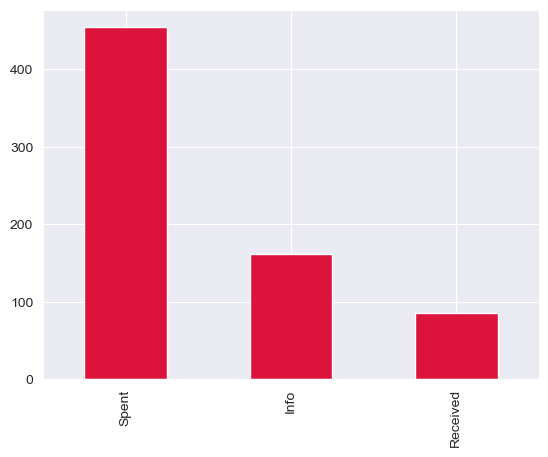

In [14]:
dt.transac_type.value_counts().plot(kind = 'bar',
                                    color = 'crimson')
plt.show()

## Data Pre Processing

In natural language processing (NLP), text data is represented as a sequence of words or tokens. However, most machine learning algorithms and models are designed to work with numerical data. This is where embedding and vectorization come in.

Vectorization is the process of converting text data into numerical vectors that can be used by machine learning algorithms. 

Embedding, on the other hand, is a technique used to represent words as dense numerical vectors that capture the semantic meaning of words. Word embeddings are created using unsupervised learning which analyze the co-occurrence patterns of words in a large corpus of text data to learn high-dimensional representations of words.

 This allows for more efficient and effective modeling of natural language data, leading to better performance on NLP tasks such as sentiment analysis, text classification, and language translation.

In the case of text messages, the length of messages can vary widely from just a few words to several paragraphs. If we were to use a fixed embedding dimension for all messages, we might run into issues where longer messages have embeddings that are too compressed, resulting in a loss of information, or shorter messages have embeddings that are too sparse, resulting in overfitting.

By checking the length of messages before deciding on the embedding dimension, we can choose an appropriate embedding dimension that is proportional to the length of the message.

In [15]:
dt['text_length'] = dt["mess_bod"].apply(lambda x : len(x.split()))

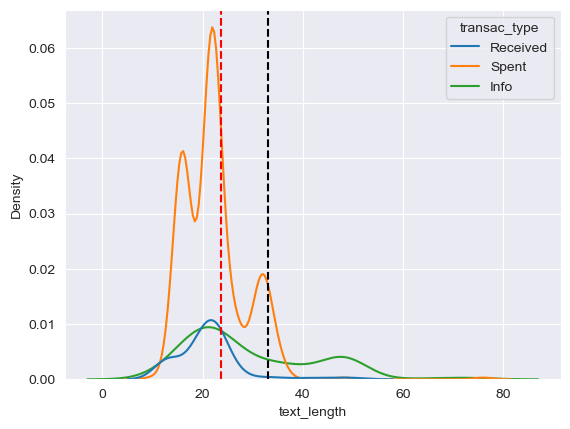

In [16]:
sns.kdeplot(data = dt,x = dt['text_length'],hue = dt['transac_type'])
plt.axvline(dt.text_length.mean(),color = 'red',linestyle ='--')
plt.axvline(np.quantile(dt.text_length,0.9),color = 'k',linestyle ='--')
plt.show()

The mean of the lengths of the messages is around 25, 90% of the text messages are below the length of around 35, we can choose the embedding dimension to be 35 that will have 90% of the information from all the text messages, but as we know machine learning/AI models are as capable as the data fed to them and clearly a pattern is visible that the messages with length range from 40-60 are more likely to be a Information message so we will go ahead and select the embedding dimension to be 60

In [17]:
max_seq_length = 60

I will not be sharing my personal transactional messages on the internet as privacy can be controlled in this scenario 😈.\
So let us create three messages text(imaginary) for the purpose of this report.

Info : Your EMI of RS. 14999 is due on 2nd of upcoming month for the purchase of PS5 from amazon against your credit card\
Received : Received rs. 51 in your bank account for the stale gulab jaamun from zomato\
Spent : rs. 18 has been debited from your bank account against upi blahblah@paytm transaction id 7777777777777



In [18]:
string_one = "Your EMI of RS. 14999 is due on 2nd of upcoming month for the purchase of PS5 from amazon against your credit card."
string_two = "Received rs. 51 in your bank account for the stale gulab jaamun from zomato."
string_three = "Rs. 18 has been debited from your bank account against upi blahblah@paytm transaction id 7777777777777."

We need to standardize the raw text data that we have before we feed it into the model, for the end purpose of using this model into an android application we can use our good friend tensorflow to do so, at the end we can even incorporate this standardization into our model so that it can take raw texts and make predictions on them.

We need to remove the numbers that are present in our texts and also the punctuation, lower the case of every words.

In [19]:
def standardize_text(input_text):
    text_messages = tf.convert_to_tensor(input_text) # convert the input text to a tensor
    lower_texts = tf.strings.lower(text_messages) # convert all the characters to lowercase
    remove_nums = tf.strings.regex_replace(lower_texts,"\\d","") # replace digits in the text
    remove_spec = tf.strings.regex_replace(remove_nums,'[%s]' % re.escape(string.punctuation),'')
    return remove_spec

In [20]:
standardize_text(string_one).numpy()

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



b'your emi of rs  is due on nd of upcoming month for the purchase of ps from amazon against your credit card'

Thats neat ! now we need to decide upon a number that would be the size of our vocabulary, we will go ahead and set it with 10000 , this means that our model will have a vocabulary of 10000 words. Words other than this won't be recongnized by our model.

In [21]:
vocab_size = 10000

# initializing a vectorization layer from tensorflow.
vectorize_layer = TextVectorization(
    standardize=standardize_text,          # passing our standardize function to pre process the text 
    max_tokens=vocab_size,                 # setting the maximum vocabulary size
    output_mode='int',                     # output will be tensor containing integers value representing our texts also know as tokens in NLP domain
    output_sequence_length=max_seq_length) # our output will be this long.

Let's create a sample dataset to see what actually this layers does.

In [22]:
sampleX = [string_one,string_two,string_three]

vectorize_layer.adapt(sampleX)

In [23]:
vectorize_layer(sampleX[0])

<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([ 2, 28,  4,  3, 23, 29, 19, 20,  4, 13, 21,  7,  6, 17,  4, 18,  5,
       35,  9,  2, 31, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])>

That's too many numbers. What do they mean any way lets find out.\

Remeber we selected max_seq_length to be 60 the zeros at the end of this array represents the missing words in the sentence of length 60

In [24]:
vectorize_layer.get_vocabulary()[:5]

['', '[UNK]', 'your', 'rs', 'of']

The starting of the vocabulary list has ' ',[UNK], and then the words in our example strings.\
We can see that 'your' is 2 from the array above and the text we passed to the vectorization layer. \
' ' represents missing values or spaces.\
[UNK] represents words that are not present in the vocabulary.

Can you guess what the size of our vocabulary list would be?

In [25]:
len(vectorize_layer.get_vocabulary())

36

We only have 35 words in our three sample texts that we provided to the vectorize layer, lets initialize a new vectorize layer and adapt it to the 700 transactional messages that we have classified manually.

But first lets split our data into train test and validation set so we can check the performance of the model and make changes to some hyperparameters if required.

In [26]:
X = dt['mess_bod']
y = dt['transac_type']

# splitting into train and test_val

X_train, X_test_val, y_train, y_test_val = train_test_split(X,y,test_size=0.1,random_state=42)

#splitting into test and validation set

X_test,X_val,y_test,y_val = train_test_split(X_test_val,y_test_val,test_size=0.5,random_state=42)

print("Size of Train dataset : ", X_train.shape[0])
print("Size of Test dataset : ", X_test.shape[0])
print("Size of Val dataset : ", X_val.shape[0])

Size of Train dataset :  630
Size of Test dataset :  35
Size of Val dataset :  35


In [27]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

After the train test split of the data at hand we have 90% of data that is 630 messages for training the model, 35 to validate the model while training and 35 to the test the model at the very end.

After adapting the vectorize layer to our X_train data we have a vocabulary of size 819 a good set of words as compared to the one we received with three texts.

In [28]:
vectorize_layer.adapt(X_train)
len(vectorize_layer.get_vocabulary())

819

Now we have vectors for each sentences and we need to embed them in a higher dimension, which can be done using the Embedding layer from tensorflow. This higer dimension representation of our text will help the model to understand the meaning of the text.

For eg. We humans can interpret that words such as happy, smile, laugh are closer to each other as they describe a emotion of happines but machine don't have this capabilty , so to achieve this we create a high dimensional representation for these words so the machine can calculate the similarity of these words based on the disatance netween these arrays in a higher dimension.

To understand and see what this embedding layer does lets create a tensor array of size 4 and pass it through a embedding layer with a embedding feature set of 50 and a dimension of 3

In [29]:
tensor_array = tf.TensorArray(tf.int32,size=4)
tensor_array.write(0,12).mark_used()
tensor_array.write(1,15).mark_used()
tensor_array.write(2,45).mark_used()
tensor_array.write(3,0)

In [30]:
tensor_array.stack().numpy()

array([12, 15, 45,  0], dtype=int32)

In [31]:
Embedding(50,3)(tensor_array.stack())

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 0.02515585,  0.00162947,  0.02032625],
       [ 0.01031089, -0.02891344, -0.02378489],
       [-0.03730098,  0.01270146, -0.04216348],
       [-0.04525834,  0.02010795, -0.00100758]], dtype=float32)>

We can see that the embedding layer has created a three dimensional array from the single dimensional array that we passed to it. We will include the embedding layer with 10000 features(the max Vocab size we initialized in the beginning) and 32 dimension for our model.

Creating a Neural Net 

In [32]:
embedding_dim = 32

model = tf.keras.Sequential([
  Embedding(vocab_size + 1, embedding_dim),
  Dropout(0.3),
  GlobalAveragePooling1D(),
  Dropout(0.3),
  Dense(15,activation = 'relu'),
  Dense(3,activation = 'softmax')
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320032    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                        

In [33]:
model.compile(loss="CategoricalCrossentropy",
              optimizer='adam',
              metrics="accuracy")

Vectorizing the texts in our training, validation and test datasets before feeding them to the model.

In [34]:
X_train = vectorize_layer(X_train)
X_val = vectorize_layer(X_val)
X_test = vectorize_layer(X_test)

Fitting the model

In [35]:
history = model.fit(X_train,y_train,epochs = 60,validation_data = (X_val,y_val),verbose=0)

Evaluating the model performance on test dataset

In [36]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.2617 - accuracy: 0.9429


[0.2617080509662628, 0.9428571462631226]

What? 🫢 accuracy of 94% too good to be true, let plot the model training loss and validation loss and also the training accuracy and validation accuracy to see of the model is overfitting or not

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

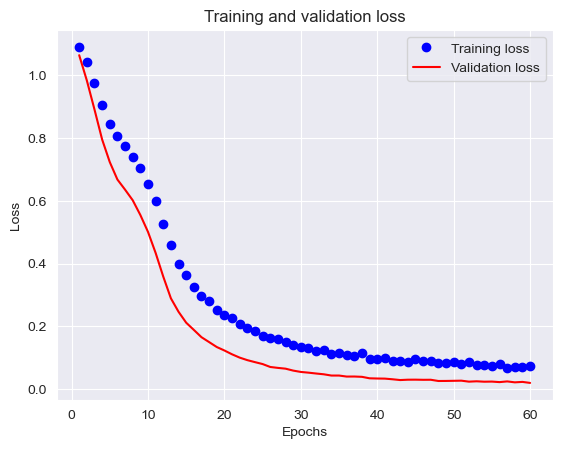

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

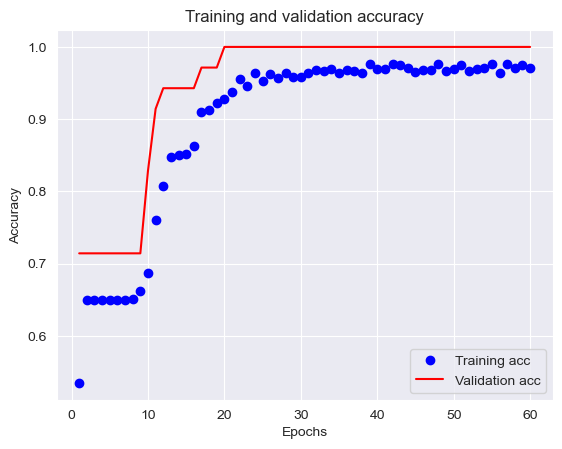

In [39]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Our model is overfitted a bit the validation accuracy is around 0.97% and our training accuracy is 100% we can work with that.\

How to overcome this overfitting?
- Gather more data and train the model on the new data 
- Use regularization or dropout layers.
- change the learning rate or play with the number of layers.

I am happy with the model that has converged and can live with the amount of overfitting that is as of now but how will this model perform on our imaginary text data, let's find out.

In [40]:
strings = vectorize_layer([string_one,string_two,string_three])

In [41]:
string_one

'Your EMI of RS. 14999 is due on 2nd of upcoming month for the purchase of PS5 from amazon against your credit card.'

In [42]:
preds = model.predict(strings)

1/1 [==============================] - 0s 71ms/step


In [43]:
categories = y_test.columns.to_list()

print(f"Our model predicted {string_one} \nwhich was orignially informational to be \n{categories[np.argmax(preds[0])]}")
print(f"Our model predicted {string_two} \nwhich was orignially Received to be \n{categories[np.argmax(preds[1])]}")
print(f"Our model predicted {string_three} \nwhich was orignially Spent to be \n{categories[np.argmax(preds[2])]}")

Our model predicted Your EMI of RS. 14999 is due on 2nd of upcoming month for the purchase of PS5 from amazon against your credit card. 
which was orignially informational to be 
Info
Our model predicted Received rs. 51 in your bank account for the stale gulab jaamun from zomato. 
which was orignially Received to be 
Received
Our model predicted Rs. 18 has been debited from your bank account against upi blahblah@paytm transaction id 7777777777777. 
which was orignially Spent to be 
Spent


So far so good , but there is plenty of room for improvement in this model, we need to collect more data and retrain it with that data as the model in real life does not perform this well, How do I know? I created an android app for it classify my text messages for me and it disappointed me 😢 at the same time motivated to somehow completed the classification of the remaining text messages in the dataset, which is one of the future scope of this project.

Saving Model 

To save our model we will first merge the model with vectorization layer so that in our android app this is a single step process and we just need to pass the message text and it can output the prediction 

In [44]:
export_model = tf.keras.models.Sequential(
  [
  vectorize_layer,
  model
])

export_model.compile(loss="CategoricalCrossentropy",
              optimizer='adam',
              metrics="accuracy")

export_model.predict([string_one])

1/1 [==============================] - 0s 76ms/step


array([[0.9580095 , 0.03185103, 0.0101395 ]], dtype=float32)

In [45]:
converter = tf.lite.TFLiteConverter.from_keras_model(export_model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /var/folders/wp/c795nqfs46j5_26txxp3ggbh0000gn/T/tmptn8zlxoq/assets


In [46]:
with open('classification_text.tflite', 'wb') as f:
  f.write(tflite_model)

In [47]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 5 nodes delegated out of 19 nodes with 2 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [48]:
input_data = np.array([string_one])
interpreter.set_tensor(input_index, input_data)
interpreter.invoke()
interpreter.get_tensor(output_index)

array([[0.9580095 , 0.03185105, 0.01013951]], dtype=float32)